In [1]:
%matplotlib inline

import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


rows,cols=(224,224)


#图像加载以及预处理
image_path="picture/cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (rows,cols))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = Variable(torch.from_numpy(img).to(device).float())
print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()

label=np.argmax(model(img).data.cpu().numpy())
print("label={}".format(label))


torch.Size([1, 3, 224, 224])
label=388


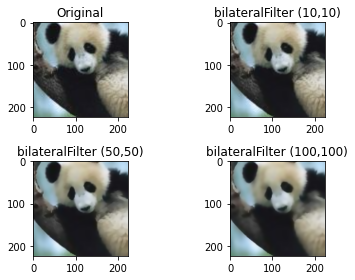

In [3]:
img2=cv2.bilateralFilter(orig.copy(),11,10,10)
img3=cv2.bilateralFilter(orig.copy(),11,50,50)
img4=cv2.bilateralFilter(orig.copy(),11,100,100)
 

plt.subplot(221)
plt.imshow(orig,cmap=plt.cm.gray) 
plt.title("Original")

plt.subplot(222)
plt.imshow(img2,cmap=plt.cm.gray) 
plt.title("bilateralFilter (10,10)")

plt.subplot(223)
plt.imshow(img3,cmap=plt.cm.gray) 
plt.title("bilateralFilter (50,50)")

plt.subplot(224)
plt.imshow(img4,cmap=plt.cm.gray) 
plt.title("bilateralFilter (100,100)")

plt.tight_layout()

In [4]:
def infer_img(img,t=0):
    
    img=img.astype(np.float32)
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img /= 255.0
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)

    img=np.expand_dims(img, axis=0)

    img = Variable(torch.from_numpy(img).to(device).float())
    #print(img.shape)

    #使用预测模式 主要影响droupout和BN层的行为
    model = models.alexnet(pretrained=True).to(device).eval()
    
    
    output=F.softmax(model(img),dim=1)
        
    label=np.argmax(output.data.cpu().numpy())
    #print("label={}".format(label))
    
    pro=output.data.cpu().numpy()[0][label]
    
    #当t不为0时返回指定类别的概率
    if t != 0:
        pro=output.data.cpu().numpy()[0][t]
        
    
    #print("{}={}".format(t,pro))
    return pro

In [5]:
print(infer_img(orig))
print(infer_img(orig,t=288))
print(infer_img(orig,t=388))

0.92705107
3.1764077e-06
0.92705107


rotate=0 pro[388]=0.9270523190498352
rotate=10 pro[388]=0.9134761691093445
rotate=20 pro[388]=0.8514569401741028
rotate=30 pro[388]=0.8163001537322998
rotate=40 pro[388]=0.800558865070343
rotate=50 pro[388]=0.7746126651763916
rotate=60 pro[388]=0.7257903218269348
rotate=70 pro[388]=0.6808078289031982
rotate=80 pro[388]=0.6647576093673706
rotate=90 pro[388]=0.6600148677825928
rotate=100 pro[388]=0.6586408615112305
rotate=110 pro[388]=0.6677431464195251
rotate=120 pro[388]=0.6739978790283203
rotate=130 pro[388]=0.6755168437957764
rotate=140 pro[388]=0.6763970851898193
rotate=150 pro[388]=0.6717150807380676
rotate=160 pro[388]=0.6696773171424866
rotate=170 pro[388]=0.6554020047187805
rotate=180 pro[388]=0.641911506652832
rotate=190 pro[388]=0.6264170408248901
rotate=200 pro[388]=0.606657087802887
rotate=210 pro[388]=0.5844482183456421
rotate=220 pro[388]=0.5654921531677246
rotate=230 pro[388]=0.5468305349349976
rotate=240 pro[388]=0.5349426865577698
rotate=250 pro[388]=0.5189899206161499


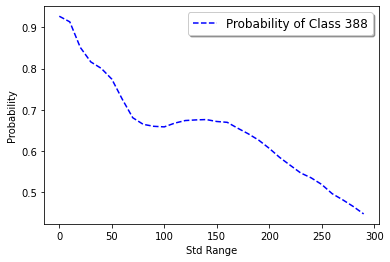

In [6]:
#验证原始图片对滤波器的鲁棒性
std_range = range(0,300,10)
original_pro = []

for i in std_range:
    
    bilateralFilter_img=cv2.bilateralFilter(orig.copy(),11,i,i)
    pro=infer_img(bilateralFilter_img.copy(),388)
    print("rotate={} pro[388]={}".format(i,pro))
    original_pro += [pro]

fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(original_pro), 'b--', label='Probability of Class 388')


legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Std Range')
plt.ylabel('Probability')
plt.show()

In [7]:
#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False
    
optimizer = torch.optim.Adam([img])
loss_func = torch.nn.CrossEntropyLoss()

epochs=100
e=0.007

target=288
target=Variable(torch.Tensor([float(target)]).to(device).long())

for epoch in range(epochs):
    
    # forward + backward
    #output = model(img)
    output = F.softmax(model(img),dim=1)

    loss = loss_func(output, target)
    label=np.argmax(output.data.cpu().numpy())
    pro=output.data.cpu().numpy()[0][label]
    
    print("epoch={} loss={} label={} pro={}".format(epoch,loss,label,pro))
    
    #如果定向攻击成功 并且概率大于阈值
    if (label == target) and ( pro > 0.80):
        print("")
        break
         
    #梯度清零
    optimizer.zero_grad()
    #反向传递 计算梯度   
    loss.backward()
    
    img.data=img.data-e*torch.sign(img.grad.data)


epoch=0 loss=6.909350872039795 label=388 pro=0.9270510673522949
epoch=1 loss=6.908727645874023 label=388 pro=0.13727833330631256
epoch=2 loss=6.907970905303955 label=387 pro=0.08647046983242035
epoch=3 loss=6.899903297424316 label=219 pro=0.05867677181959152
epoch=4 loss=6.813358783721924 label=293 pro=0.09739573299884796
epoch=5 loss=6.60948371887207 label=288 pro=0.2993808686733246
epoch=6 loss=6.450402736663818 label=288 pro=0.4584883451461792
epoch=7 loss=6.361993789672852 label=288 pro=0.5469864010810852
epoch=8 loss=6.124091625213623 label=288 pro=0.7850754261016846
epoch=9 loss=6.025216579437256 label=288 pro=0.8840774893760681



/home/miles/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/autograd/__init__.py:175: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [1, 3, 224, 224], strides() = [3, 1, 672, 3]
param.sizes() = [1, 3, 224, 224], strides() = [150528, 1, 672, 3] (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/autograd/functions/accumulate_grad.h:192.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


In [8]:
#把对抗样本转换成正常图片
adv=img.data.cpu().numpy()[0]
print(adv.shape)

adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
adv = np.clip(adv, 0, 255).astype(np.uint8)

print(adv.shape)

(3, 224, 224)
(224, 224, 3)


rotate=0 pro[388]=0.9270523190498352 pro[288]=3.174298399244435e-06
rotate=10 pro[388]=0.9134761691093445 pro[288]=2.0379732177389087e-06
rotate=20 pro[388]=0.8514569401741028 pro[288]=1.5381438061012886e-06
rotate=30 pro[388]=0.8163001537322998 pro[288]=9.006607228911889e-07
rotate=40 pro[388]=0.800558865070343 pro[288]=7.399390824502916e-07
rotate=50 pro[388]=0.7746126651763916 pro[288]=7.542600997112459e-07
rotate=60 pro[388]=0.7257903218269348 pro[288]=8.903760431167029e-07
rotate=70 pro[388]=0.6808078289031982 pro[288]=1.0396038305771071e-06
rotate=80 pro[388]=0.6647576093673706 pro[288]=1.1334390137562877e-06
rotate=90 pro[388]=0.6600148677825928 pro[288]=1.2560967661556788e-06
rotate=100 pro[388]=0.6586408615112305 pro[288]=1.4875829492666526e-06
rotate=110 pro[388]=0.6677431464195251 pro[288]=1.8176791627411149e-06
rotate=120 pro[388]=0.6739978790283203 pro[288]=2.284294851051527e-06
rotate=130 pro[388]=0.6755168437957764 pro[288]=3.0353367037605494e-06
rotate=140 pro[388]=0.67

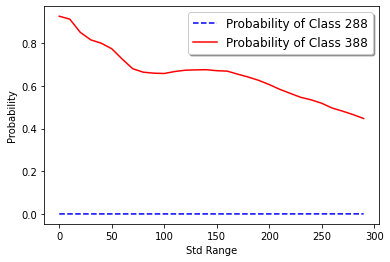

In [9]:
#验证滤波器 对抗样本的影响
std_range = range(0,300,10)
adv_288_pro = []
adv_388_pro = []

for i in std_range:
    
    bilateralFilter_img=cv2.bilateralFilter(orig.copy(),11,i,i)
    
    pro_388=infer_img(bilateralFilter_img.copy(),388)
    pro_288=infer_img(bilateralFilter_img.copy(),288)
    print("rotate={} pro[388]={} pro[288]={}".format(i,pro_388,pro_288))
    adv_288_pro += [pro_288]
    adv_388_pro += [pro_388]

fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_288_pro), 'b--', label='Probability of Class 288')
ax.plot(np.array(std_range), np.array(adv_388_pro), 'r', label='Probability of Class 388')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Std Range')
plt.ylabel('Probability')
plt.show()

rotate=0 adv_pro[388]=2.366358421568293e-05 original_pro[388]=0.9270523190498352
rotate=10 adv_pro[388]=0.02550089731812477 original_pro[388]=0.9134761691093445
rotate=20 adv_pro[388]=0.14908848702907562 original_pro[388]=0.8514569401741028
rotate=30 adv_pro[388]=0.29887130856513977 original_pro[388]=0.8163001537322998
rotate=40 adv_pro[388]=0.45596039295196533 original_pro[388]=0.800558865070343
rotate=50 adv_pro[388]=0.5363848805427551 original_pro[388]=0.7746126651763916
rotate=60 adv_pro[388]=0.521619975566864 original_pro[388]=0.7257903218269348
rotate=70 adv_pro[388]=0.5116597414016724 original_pro[388]=0.6808078289031982
rotate=80 adv_pro[388]=0.5086101293563843 original_pro[388]=0.6647576093673706
rotate=90 adv_pro[388]=0.5193538069725037 original_pro[388]=0.6600148677825928
rotate=100 adv_pro[388]=0.5200128555297852 original_pro[388]=0.6586408615112305
rotate=110 adv_pro[388]=0.5316625833511353 original_pro[388]=0.6677431464195251
rotate=120 adv_pro[388]=0.5531915426254272 ori

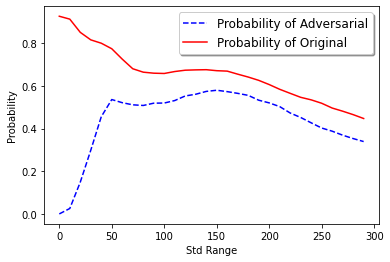

In [10]:

#综合分析滤波对 对抗样本和正常图片分类的影响
std_range = range(0,300,10)
original_pro = []
adv_pro = []

for i in std_range:
    
    bilateralFilter_adv_img=cv2.bilateralFilter(adv.copy(),11,i,i)
    pro_388=infer_img(bilateralFilter_adv_img.copy(),388) 
    adv_pro+= [pro_388]
    
    bilateralFilter_img=cv2.bilateralFilter(orig.copy(),11,i,i)
    pro=infer_img(bilateralFilter_img.copy(),388)
    original_pro += [pro]
            
    print("rotate={} adv_pro[388]={} original_pro[388]={}".format(i,pro_388,pro))


fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_pro), 'b--', label='Probability of Adversarial')
ax.plot(np.array(std_range), np.array(original_pro), 'r', label='Probability of Original')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Std Range')
plt.ylabel('Probability')
plt.show()

如图，横轴代表双边滤波标准差，纵轴表示预测概率，实现代表原始图像预测为熊猫的概率，虚线代表对抗样本预测为熊猫的概率。我们假设分类概率大于百分之五十的时候结果可信，那么可以认为当双边滤波器标准差大于50小于280的时候 原有模型可有效抵抗定向攻击样本 同时不影响正常图像分类